# Twelve-dimensional Model of Heat Transfer through a Dual-Pane Window
## Sparse Quadrature only
This script produces a probability density function of the heat flux for a twelve-dimensional model, using fourth order PCE’s and non-intrusive spectral projection with sparse quadrature.

In [18]:
#general imports

from __future__ import print_function

try:
    import numpy as np
except ImportError:
    print("Numpy module could not be found")

try:
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('mathtext', default='regular')
except ImportError:
    print("Matplotlib not found")

try:
    from scipy import stats
except ImportError:
    print("Scipy stats module could not be found")

try:
    import PyUQTk.pce as uqtkpce
except ImportError:
    print("PyUQTk PCE module not found")
    
try:
    import PyUQTk.PyPCE.pce_tools as pce_tools
except ImportError:
    print("PyUQTk pce_tools module not found")     

In [19]:
#problem-specific imports
try:
    from tools_conductance_dp_pce_wrad import *
except ImportError:
    print("File with PCE utilities not found.")

## Setting input arguments

In [20]:
main_verbose = 0 #1 for intermediate print statements, otherwise set to 0
nord = 3 # Order of the PCE; may be increased, however the number of points produced will increase dramatically
ndim = 12 # Number of dimensions of the PCE
pc_type = "HG" #PC type
pc_alpha = 0.0 #Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0 #Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
param= nord+1 # Quad points per dimension for full quadrature or level for sparse quadrature
n_kde = 100000 # Number of random samples for KDE

In [21]:
# The uncertain, Gaussian parameters used to calculate the heat flux
Ti = 293.0 # Room temperature (K)
To = 273.0 # Outside temperature (K)
dw = 0.005 # Width of the glass pane (m)
da = 0.01  # Width of the gap between the panes (m)
kw = 1.0   # Conduction constant for glass (W/m*K)
ka = 0.024 # Conduction constant for air (W/m*K)
hi = 2.0   # Coefficient of convection inside (W/m^2*s)
ho = 6.0   # Coefficient of convection outside (W/m^2*s)
Ts = 200.0   # Sky temperature (K)
mu = 1.86e-5 # Viscosity of air (kg/m*s)
rho = 1.29 # Density of air (kg/m^3)
beta = 3.67e-3 # Coefficient of thermal exspansion (1/K)

# Set the standard deviations of these uncertain parameters
std_Ti=Ti*0.005
std_To=To*0.01
std_dw=dw*0.01
std_da=da*0.01
std_kw=kw*0.05
std_ka=ka*0.05
std_hi=hi*0.15
std_ho=ho*0.15
std_Ts=Ts*0.1
std_mu=mu*0.05
std_rho=rho*0.05
std_beta=beta*0.05

## Forward Propagation using PCEs

In [22]:
print("Performing forward UQ using sparse quadrature for a", ndim, "dimensional PCE of order",nord)

# Instantiate PC Object with sparse quadrature methods
pc_model2 = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type,pc_alpha,pc_beta)
pc_model2.SetQuadRule(pc_type,'sparse',param)
npce2 = pc_model2.GetNumberPCTerms() # Number of terms in the PCE
if main_verbose > 0:
    print("The number of terms in each PCE is ",npce2)
    print("Multi-index and norm squared for all terms:")
    pc_model2.PrintMultiIndexNormSquared()

Performing forward UQ using sparse quadrature for a  12  dimensional PCE of order  3
KUKU 0 1
KUKU 0 12
KUKU 1 12
KUKU 2 12
KUKU 3 12
KUKU 4 12
KUKU 5 12
KUKU 6 12
KUKU 7 12
KUKU 8 12
KUKU 9 12
KUKU 10 12
KUKU 11 12
KUKU 0 78
KUKU 1 78
KUKU 2 78
KUKU 3 78
KUKU 4 78
KUKU 5 78
KUKU 6 78
KUKU 7 78
KUKU 8 78
KUKU 9 78
KUKU 10 78
KUKU 11 78
KUKU 12 78
KUKU 13 78
KUKU 14 78
KUKU 15 78
KUKU 16 78
KUKU 17 78
KUKU 18 78
KUKU 19 78
KUKU 20 78
KUKU 21 78
KUKU 22 78
KUKU 23 78
KUKU 24 78
KUKU 25 78
KUKU 26 78
KUKU 27 78
KUKU 28 78
KUKU 29 78
KUKU 30 78
KUKU 31 78
KUKU 32 78
KUKU 33 78
KUKU 34 78
KUKU 35 78
KUKU 36 78
KUKU 37 78
KUKU 38 78
KUKU 39 78
KUKU 40 78
KUKU 41 78
KUKU 42 78
KUKU 43 78
KUKU 44 78
KUKU 45 78
KUKU 46 78
KUKU 47 78
KUKU 48 78
KUKU 49 78
KUKU 50 78
KUKU 51 78
KUKU 52 78
KUKU 53 78
KUKU 54 78
KUKU 55 78
KUKU 56 78
KUKU 57 78
KUKU 58 78
KUKU 59 78
KUKU 60 78
KUKU 61 78
KUKU 62 78
KUKU 63 78
KUKU 64 78
KUKU 65 78
KUKU 66 78
KUKU 67 78
KUKU 68 78
KUKU 69 78
KUKU 70 78
KUKU 71 78
KU

In [23]:
#Get NumPy array of quadrature points
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)

print("Sparse quadrature method requires model evaluations at ", totquat2, " points")
print("This may take a while if the chosen order is > 3")

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
# Taking advantage of the fact that inputs are assumed to be Gaussian
# Following parameter_samples = μ + σ(qdpts)
# This is equivalent to evaluating 1st order PC expansions for the input parameters.
Ti_samples2 = Ti + std_Ti * qdpts2[:,0]
To_samples2 = To + std_To * qdpts2[:,1]
dw_samples2 = dw + std_dw * qdpts2[:,2]
da_samples2 = da + std_da * qdpts2[:,3]
kw_samples2 = kw + std_kw * qdpts2[:,4]
ka_samples2 = ka + std_ka * qdpts2[:,5]
hi_samples2 = hi + std_hi * qdpts2[:,6]
ho_samples2 = ho + std_ho * qdpts2[:,7]
Ts_samples2 = Ts + std_Ts * qdpts2[:,8]
mu_samples2 = mu + std_mu * qdpts2[:,9]
rho_samples2 = rho + std_rho * qdpts2[:,10]
beta_samples2 = beta + std_beta * qdpts2[:,11]

# Evaluate forward model for sampled parameters, computing heat flux Q
#Q_evals is an array of evaluations of the forward model

# fwd_model first solves five linear equations, neglecting convection for the air gap and radiative heat transfer
# Then, these values are used as initial inputs for full calculations using a nonlinear solver
Q_evals2=fwd_model(Ti_samples2,To_samples2,Ts_samples2,dw_samples2,da_samples2,kw_samples2,\
ka_samples2,hi_samples2,ho_samples2,mu_samples2,rho_samples2,beta_samples2)

# Galerkin Projection
c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,Q_evals2)

# Generate germ samples
germ_samples2=np.random.normal(0,1, (n_kde,ndim))

# Evaluate the PCE at the germ samples
pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)

# Peform kernel density estimation
xpts_pce2, PDF_data_pce2=pce_tools.UQTkKDE(pce_evals2)

165 364
KUKU 166 364
KUKU 167 364
KUKU 168 364
KUKU 169 364
KUKU 170 364
KUKU 171 364
KUKU 172 364
KUKU 173 364
KUKU 174 364
KUKU 175 364
KUKU 176 364
KUKU 177 364
KUKU 178 364
KUKU 179 364
KUKU 180 364
KUKU 181 364
KUKU 182 364
KUKU 183 364
KUKU 184 364
KUKU 185 364
KUKU 186 364
KUKU 187 364
KUKU 188 364
KUKU 189 364
KUKU 190 364
KUKU 191 364
KUKU 192 364
KUKU 193 364
KUKU 194 364
KUKU 195 364
KUKU 196 364
KUKU 197 364
KUKU 198 364
KUKU 199 364
KUKU 200 364
KUKU 201 364
KUKU 202 364
KUKU 203 364
KUKU 204 364
KUKU 205 364
KUKU 206 364
KUKU 207 364
KUKU 208 364
KUKU 209 364
KUKU 210 364
KUKU 211 364
KUKU 212 364
KUKU 213 364
KUKU 214 364
KUKU 215 364
KUKU 216 364
KUKU 217 364
KUKU 218 364
KUKU 219 364
KUKU 220 364
KUKU 221 364
KUKU 222 364
KUKU 223 364
KUKU 224 364
KUKU 225 364
KUKU 226 364
KUKU 227 364
KUKU 228 364
KUKU 229 364
KUKU 230 364
KUKU 231 364
KUKU 232 364
KUKU 233 364
KUKU 234 364
KUKU 235 364
KUKU 236 364
KUKU 237 364
KUKU 238 364
KUKU 239 364
KUKU 240 364
KUKU 241 364
KUKU

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


## Summary Information


td_heat_flux_pce.pdf has been saved.


NameError: name 'datetime' is not defined

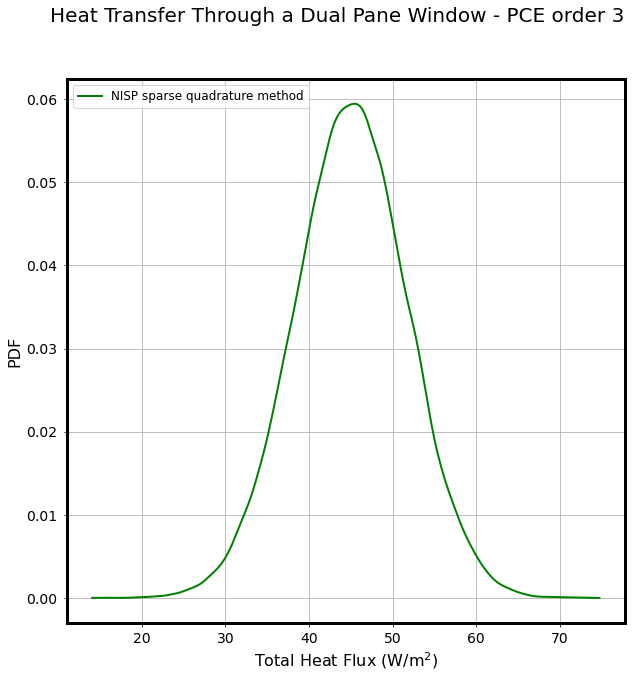

In [25]:
# Plot the PDF curve
plt.figure(figsize=(10,10))
plt.plot(xpts_pce2, PDF_data_pce2, linewidth=2, color='g', label= 'NISP sparse quadrature method')
# Label Axes
plt.xlabel(r'Total Heat Flux ($W/m^2$)', size=16)
plt.ylabel("PDF", size=16)
# Add title
plt.suptitle("Heat Transfer Through a Dual Pane Window - PCE order %s"%(nord), size=20)
# Change tick size
plt.tick_params(axis='both', labelsize=14)
# Pad tick labels
plt.gca().tick_params(pad=6)
# Create legend
plt.legend(loc='upper left', prop={'size':12})
# Save figure
fig_name="td_heat_flux_pce.pdf"
plt.savefig(fig_name)
print("\ntd_heat_flux_pce.pdf has been saved.")
# Show figure
plt.show()